In [1]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers import LSTM, TimeDistributed


Using TensorFlow backend.


# Put all the CSV files into 'files' folders (Make sure all prediction will happen for same date and shape of all CSV file is same)

***




## <center>Load the stock data</center>

### Choose CSV file of the company stock price

In [2]:
! ls

files  new.ipynb


In [3]:
import os
path =r'/home/aurobindo/Stock_prices/Stock_prices/files/'

os.chdir(path)
arr = os.listdir()
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [4]:
import glob

#path =r'/mapr_data/auro_157072/business_news/news_02/Stock/Files'
filenames = glob.glob(path + "/*.csv")

In [5]:
glob.glob(path +"/*.csv")

['/home/aurobindo/Stock_prices/Stock_prices/files/Facebook.csv',
 '/home/aurobindo/Stock_prices/Stock_prices/files/Amazon.csv',
 '/home/aurobindo/Stock_prices/Stock_prices/files/Apple.csv']

# We predict the close value

In [6]:
dfs = []
for index,filename in enumerate(filenames):
    df = pd.read_csv(filename)
    
    close_name = 'Close_' + arr[index][:-4]
    col_names = ['Timestamp','Sequence','Open','High','Low',close_name,'Volume']
    df.columns = col_names
    df['Timestamp'] =  pd.to_datetime(df['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    df.index = df['Timestamp']
    df = df.drop(['Sequence','Timestamp'],axis =1)
    
    
    
    # Choose the date in this format for all given csv files 
    
    df = df[[close_name]]
    
    
    # Need to change for new files
    df = df.loc['2018-03-14']
    
    dfs.append(df)

In [7]:
len(dfs)

3

In [8]:
dfs[0].shape

(391, 1)

In [9]:
arr

['Facebook.csv', 'Amazon.csv', 'Apple.csv']

In [10]:
result = pd.concat(dfs, axis=1)
result.shape

(391, 3)

In [11]:
result.head(1)

Close_Facebook  Close_Amazon  Close_Apple
Timestamp                                                     
2018-03-14 13:30:00           182.6        1597.0       180.32

# Visualisation

<Figure size 1080x576 with 0 Axes>

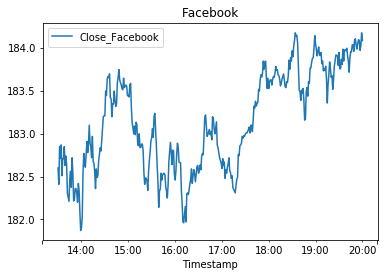

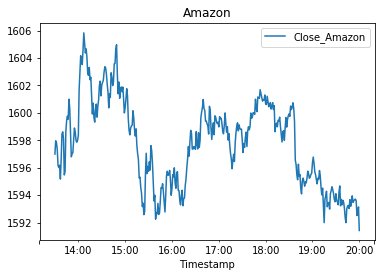

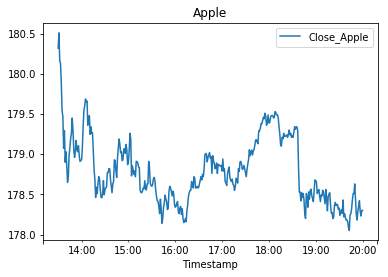

In [12]:
plt.figure(figsize=(15,8))

for i in range(len(dfs)):
    #plt.subplot(i,1,1)
    result.iloc[:, [i]].plot()
    plt.title(arr[i][:-4])


plt.legend()
plt.show()

# Shape of the merged csv files

In [13]:
result.shape

(391, 3)

# For final script we take all data points

In [14]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]

def new_scale(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data)
    # transform train
    data = data.reshape(data.shape[0], data.shape[1])
    data_scaled = scaler.transform(data)

    return scaler, data_scaled



def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [15]:
#result.iloc[:, [2]].head()

In [16]:
trains,train_scaleds,tests,test_scaleds  = [],[],[],[]
# trains,train_scaleds = [],[]


for i in range(len(dfs)):
    series = result.iloc[:, [i]]
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    supervised = timeseries_to_supervised(diff_values, 4)
    supervised_values = supervised.values
    
    
    
    # # Need to change for new files
    train, test = supervised_values[0:-100], supervised_values[-100:]
    
    # uncomment next lines for final version
    #train = supervised_values[0:]
    
    
    
    trains.append(train)
    
    # comment this line
    tests.append(test)
    
    # comment this line
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # uncomment this line
    # train_scaled = new_scale(train)
    
    train_scaleds.append(train_scaled)
    
    # comment this line
    test_scaleds.append(test_scaled)

/home/aurobindo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
merge_train = np.insert(trains[0][:,:-1],[4],trains[1][:,:-1], axis=1)

# comment this line
merge_test = np.insert(tests[0][:,:-1],[4],tests[1][:,:-1], axis=1)

for i in range(len(dfs)-2):
    merge_train = np.insert(merge_train,[4 * (i+2)],trains[i+2][:,:-1], axis=1)
    
    # comment this line
    merge_test  = np.insert(merge_test,[4 * (i+2)],tests[i+2][:,:-1], axis=1)
    

In [18]:
print(merge_train.shape)

# comment this line
print(merge_test.shape)

(290, 12)
(100, 12)


In [19]:
l_trains = []

# comment this line
l_tests = []
for i in range(len(dfs)):

    l_train = trains[i][:,-1].reshape(trains[i][:,-1].shape[0],1)
    l_trains.append(l_train)
    
    # comment these line
    l_test = tests[i][:,-1].reshape(tests[i][:,-1].shape[0],1)
    l_tests.append(l_test)

In [20]:
merge_train_output = np.concatenate(tuple(l_trains),axis=1)

# comment this line
merge_test_output = np.concatenate(tuple(l_tests),axis=1)

In [21]:
print(merge_train_output.shape)

# comment this line
print(merge_test_output.shape)

(290, 3)
(100, 3)


In [22]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

In [23]:
X, y = merge_train, merge_train_output
X = X.reshape(X.shape[0], 1, X.shape[1])
y = y.reshape(y.shape[0], 1, y.shape[1])


# Comment these lines
X_test, y_test = merge_test, merge_test_output
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])



model = Sequential()

'''
model.add(LSTM(12, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=False,return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(18,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(8,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=3))
model.add(Activation('linear'))

'''

# To be changed 
dim_in = 4 * len(dfs)
dim_out = len(dfs)
nb_units = 7


model.add(LSTM(input_shape=(1, dim_in),
                    return_sequences=True, 
                    units=nb_units))

model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(activation='selu', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

#print(X.shape)
#history = model.fit(X, y, epochs = 200, batch_size = 1,verbose=0,validation_data=(X_test, y_test),callbacks=[plot_losses])
              
              
#model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

# To be changed according to our requirement (200 min)
for i in range(200):
    print("Completed :",i+1,"/",200, "Steps")
    model.fit(X, y, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

Completed : 1 / 200 Steps
Epoch 1/1
 - 2s - loss: 0.2639
Completed : 2 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2514
Completed : 3 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2487
Completed : 4 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2473
Completed : 5 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2448
Completed : 6 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2456
Completed : 7 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2435
Completed : 8 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2403
Completed : 9 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2395
Completed : 10 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2418
Completed : 11 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2382
Completed : 12 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2381
Completed : 13 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2347
Completed : 14 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2385
Completed : 15 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2378
Completed : 16 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2413
Completed : 17 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2362
Completed : 18 / 200 St

Completed : 142 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2128
Completed : 143 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2150
Completed : 144 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2176
Completed : 145 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2127
Completed : 146 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2085
Completed : 147 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2106
Completed : 148 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2126
Completed : 149 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2136
Completed : 150 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2066
Completed : 151 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2101
Completed : 152 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2062
Completed : 153 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2128
Completed : 154 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2114
Completed : 155 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2088
Completed : 156 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2147
Completed : 157 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.2077
Completed : 158 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.20

In [24]:
result.shape[0]

391

In [25]:
train_scaled.shape

(290, 5)

In [26]:
# Total number of forecasted values
total_minutes = 390 - train_scaled.shape[0]
total_minutes

100

In [27]:
def forecast_lstm(model, X):
    y = model.predict(X)
    return y

ts = []
base_values = []

for i in range(len(dfs)):
    t = merge_train[-1:,4*i : 4*(i+1)]
    ts.append(t)
    
    # change 290 to (result.shape[0] - 1) for final prediction
    base_values.append(result.iloc[train_scaled.shape[0]][i])

predictions = []

prediction = np.zeros((total_minutes,len(dfs)))


prediction_i = np.zeros((total_minutes,len(dfs)))

                        

for i in range(total_minutes):
    temp = []
    for j in range(len(dfs)):
        temp.append(ts[j][:,i:])
    
    test_pred = np.concatenate(tuple(temp),axis=1)
    input_data = test_pred.reshape(1, 1, 4 *  len(dfs))
    
    y = forecast_lstm(model,input_data)
    prediction[i] = y[0]
    
    ys =[]
    
    for k in range(len(dfs)):
        ts[k] = np.insert(ts[k],[i+4],y[0][0][k], axis=1)
        
        temp = base_values[k] + y[0][0][k]
        prediction_i[i][k] = temp
    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.3932250713851922

## Future predictions

In [28]:
prediction_i[:,:].shape

(100, 3)

In [29]:
# 100 next prediction for 1st company 
print(prediction_i[:,0])


[183.62870269 183.6366197  183.64173997 183.62427632 183.63653825
 183.630966   183.63793566 183.63264051 183.6349593  183.63292087
 183.63378146 183.63346662 183.63394978 183.63401281 183.63398299
 183.63388539 183.63376341 183.63376244 183.6337878  183.633853
 183.63387778 183.63387447 183.63384806 183.6338262  183.63382079
 183.63382897 183.63384156 183.63384827 183.63384743 183.63384184
 183.63383696 183.63383553 183.6338373  183.63384002 183.6338416
 183.63384146 183.63384027 183.63383917 183.63383882 183.63383919
 183.63383979 183.63384015 183.63384013 183.63383987 183.63383963
 183.63383955 183.63383962 183.63383975 183.63383983 183.63383983
 183.63383978 183.63383972 183.6338397  183.63383972 183.63383975
 183.63383977 183.63383977 183.63383976 183.63383974 183.63383974
 183.63383974 183.63383975 183.63383975 183.63383976 183.63383975
 183.63383975 183.63383975 183.63383975 183.63383975 183.63383975
 183.63383975 183.63383975 183.63383975 183.63383975 183.63383975
 183.63383975

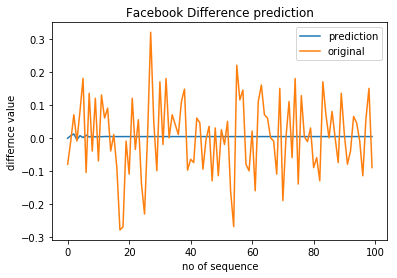

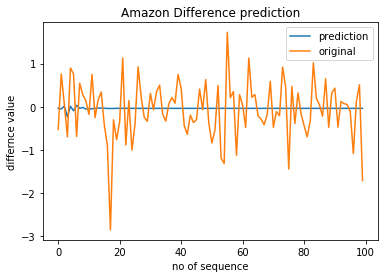

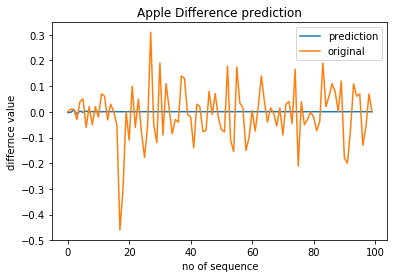

In [30]:
for i in range(len(dfs)):
    plt.plot(prediction[:,i:i+1],label="prediction")
    
    # comment this line
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

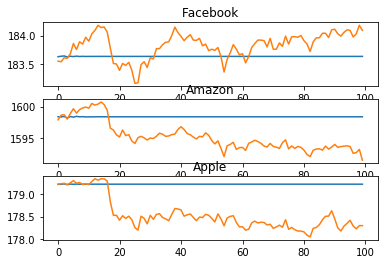

In [31]:

for i in range(len(dfs)):
    plt.subplot(3,1,i+1)
    plt.plot(prediction_i[:,i])
    
    # comment this line
    plt.plot(result.iloc[:, [i]].iloc[-100:].values)
    plt.title(arr[i][:-4])
plt.show()

# Parallal Process

In [32]:
print(merge_train.shape, merge_train_output.shape)

(290, 12) (290, 3)


In [33]:
from keras.models import Model
from keras.layers import *

In [34]:
def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    #features = features.reshape(features.shape[0], 1, features.shape[1])   
    #labels = labels.reshape(labels.shape[0], 1, labels.shape[1])   
    
    features = []
    labels = []
    
    # Add features 
    
    
    for i in range(len(dfs)):
    
        feature1, label1 = merge_train[:,(4*i):4*(i+1)],merge_train_output[:,i:i+1]
        feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
        label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])
        
        features.append(feature1)
        labels.append(label1)
        
    
    '''
    
    feature1, label1 = merge_train[:,0:4],merge_train_output[:,0:1]
    feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
    label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])
    
    feature2, label2 = merge_train[:,4:8],merge_train_output[:,1:2]
    feature2 = feature2.reshape(feature2.shape[0], 1, feature2.shape[1])   
    label2 = label2.reshape(label2.shape[0], 1, label2.shape[1])
    
    feature3, label3 = merge_train[:,8:12],merge_train_output[:,2:3]
    feature3 = feature3.reshape(feature3.shape[0], 1, feature3.shape[1])   
    label3 = label3.reshape(label3.shape[0], 1, label3.shape[1])
'''
    
    # Change the code
    
    #joining the models for 3 company
    
    inp1 = Input((1,4))
    inp2 = Input((1,4))
    inp3 = Input((1,4))
    # inp4 = Input((1,4))
    # Add or delete inp(i) if other than 3 company 
    
        
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, 1, 4),
                    return_sequences=True, 
                    units=nb_units))
    model.add(Dropout(0.2))
    
    
    model.add(LSTM(4,return_sequences=True))
    model.add(Dropout(0.2))

    
    model.add(TimeDistributed(Dense(activation='selu', units=dim_out)))
    
    
    # Change the code
    #joining the models for 3 company
    
    out = []
    
    for i in range(len(dfs)):
        out.append(model(inp1))
        
    out1 = model(inp1)
    out2 = model(inp2)
    out3 = model(inp3)
    # out4 = model(inp4)
    # Add or delete out(i) if other than 3 company     
    
    
    models = Model([inp1,inp2,inp3],[out1,out2,out3])
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    models.compile(loss='mean_squared_error', optimizer='adam')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    
    
    for i in range(300):
        print("Completed :",i+1,"/",300, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        models.fit(features,labels, epochs = 1,verbose=0,shuffle=False)
        models.reset_states()

    return models

In [35]:
print(merge_train[:,0:4].shape)
print(merge_train_output[:,0:1].shape)

(290, 4)
(290, 1)


In [36]:
models = fit_lstm(merge_train,merge_train_output)

Completed : 1 / 300 Steps
Completed : 2 / 300 Steps
Completed : 3 / 300 Steps
Completed : 4 / 300 Steps
Completed : 5 / 300 Steps
Completed : 6 / 300 Steps
Completed : 7 / 300 Steps
Completed : 8 / 300 Steps
Completed : 9 / 300 Steps
Completed : 10 / 300 Steps
Completed : 11 / 300 Steps
Completed : 12 / 300 Steps
Completed : 13 / 300 Steps
Completed : 14 / 300 Steps
Completed : 15 / 300 Steps
Completed : 16 / 300 Steps
Completed : 17 / 300 Steps
Completed : 18 / 300 Steps
Completed : 19 / 300 Steps
Completed : 20 / 300 Steps
Completed : 21 / 300 Steps
Completed : 22 / 300 Steps
Completed : 23 / 300 Steps
Completed : 24 / 300 Steps
Completed : 25 / 300 Steps
Completed : 26 / 300 Steps
Completed : 27 / 300 Steps
Completed : 28 / 300 Steps
Completed : 29 / 300 Steps
Completed : 30 / 300 Steps
Completed : 31 / 300 Steps
Completed : 32 / 300 Steps
Completed : 33 / 300 Steps
Completed : 34 / 300 Steps
Completed : 35 / 300 Steps
Completed : 36 / 300 Steps
Completed : 37 / 300 Steps
Completed 

Completed : 298 / 300 Steps
Completed : 299 / 300 Steps
Completed : 300 / 300 Steps


In [37]:
# Total number of forecasted values
total_minutes = 390 - train_scaled.shape[0]
total_minutes

100

In [38]:
input_data = np.copy(merge_train)
prediction = np.zeros((total_minutes,len(dfs)))
prediction_i = np.zeros((total_minutes,len(dfs)))
input_data = np.copy(merge_train[-1,:])


base_values = []


for i in range(len(dfs)):
    base_values.append(result.iloc[train_scaled.shape[0]][i])
    # change 290 to (result.shape[0] - 1) for final prediction

for i in range(total_minutes):
    ts = []
    
    for m in range(len(dfs)):
        t = input_data[4*m + i : 4*(m+1) + i]
        t = t.reshape(1,1,4)
        
        ts.append(t)
    
    y = models.predict(ts)
    prediction[i] = np.concatenate(y, axis=1 ).reshape((1,1,len(dfs)))    
    for k in range(len(dfs)):
        input_data = np.insert(input_data,[i+4*(k+1)],y[k][0][0], axis=0)
        prediction_i[i][k] = base_values[k] + y[k][0][0]    
sqrt(mean_squared_error(merge_test_output, prediction))    

0.3927849938103671

In [39]:
prediction.shape

(100, 3)

In [40]:
# 100 next prediction for 2nd company 
print(prediction_i[:,1])

[1598.20898438 1598.41052246 1598.33312988 1598.36181641 1598.35095215
 1598.35498047 1598.35351562 1598.35412598 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.35388184 1598.35388184 1598.35388184 1598.35388184 1598.35388184
 1598.

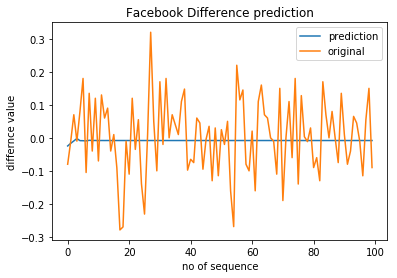

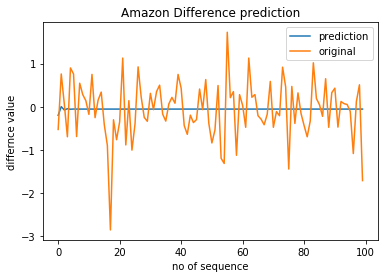

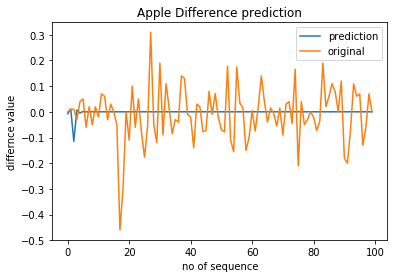

In [41]:
for i in range(len(dfs)):
    plt.plot(prediction[:,i:i+1],label="prediction")
    
    # comment this line in final prediction
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

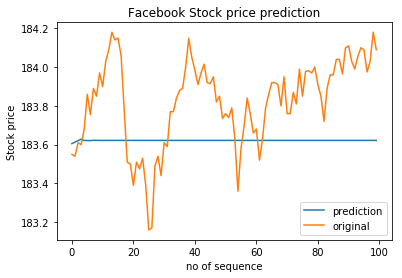

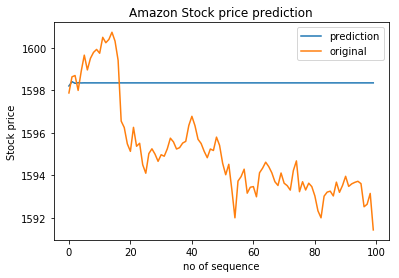

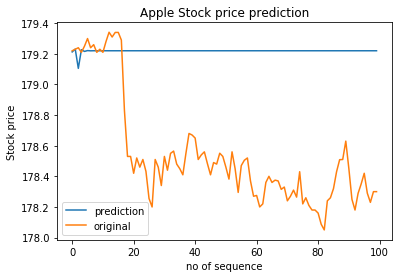

In [42]:
for i in range(len(dfs)):
    plt.plot(prediction_i[:,i:i+1],label="prediction")
    # comment this line in final prediction
    plt.plot(result.iloc[-100:,i].values,label="original")
    plt.title(arr[i][:-4]+' Stock price prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('Stock price')
    plt.legend()
    plt.show()

# Using Indivisual company

In [43]:
import livelossplot
plot_losses = livelossplot.PlotLossesKeras()

def fit_lstm(features,labels):
    
    dim_in = 4
    dim_out = 1
    nb_units = 6
    
    model = Sequential()
    model.add(LSTM(batch_input_shape=(1, features.shape[1], features.shape[2]),return_sequences=True,units=10))
    model.add(Dropout(0.1))

    model.add(LSTM(units=4,return_sequences=False))
    model.add(Dropout(0.3))
    
    #model.add(TimeDistributed(Dense(units=1)))
    #model.add(Activation('linear'))
    
    model.add((Dense(activation='selu', units=1)))
    
    
    #model.compile(loss = 'mse', optimizer = 'rmsprop')
    model.compile(loss='mse', optimizer='rmsprop')
    
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    for i in range(300):
        #print("Completed :",i+1,"/",300, "Steps")
        #model.fit(features, labels, epochs=1, batch_size=1, verbose=0, shuffle=False)
        #model.fit(features,labels, epochs = 1,batch_size=1,verbose=0,shuffle=False,callbacks=[plot_losses])
        labels= labels.reshape((labels.shape[0], 1))
        model.fit(features,labels, epochs = 1, batch_size = 1,verbose=0)
        model.reset_states()
    print('Trained a model')
    return model

In [44]:
# change 290 to (result.shape[0] - 1) for final prediction

features_l = np.zeros((len(dfs),290,1,4))
labels_l = np.zeros((len(dfs),290,1,1))

In [45]:
for i in range(len(dfs)):
    features_l[i],labels_l[i] = merge_train[:,i*4:4 + 4* i].reshape(290,1,4),merge_train_output[:,i:i+1].reshape(290,1,1)

In [46]:
print(features_l.shape)
print(labels_l.shape)

(3, 290, 1, 4)
(3, 290, 1, 1)


In [47]:
#feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
#label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])

In [48]:
#feature1, label1 = merge_train[:,8:12],merge_train_output[:,2:3]
#feature1 = feature1.reshape(feature1.shape[0], 1, feature1.shape[1])   
#label1 = label1.reshape(label1.shape[0], 1, label1.shape[1])

In [49]:
# Total number of forecasted values
total_minutes = 390 - train_scaled.shape[0]
total_minutes

100

In [50]:
prediction_diff = np.zeros((len(dfs),total_minutes))
prediction_stock = np.zeros((len(dfs),total_minutes))

for k in range(len(dfs)):
    model = fit_lstm(features_l[k],labels_l[k])
    
    # change 290 to (result.shape[0] - 1) for final prediction
    base_value = result.iloc[290,k]
    #prediction_apple = []
    #orig_pred = []
    input_data = np.copy(merge_test[0,4*k:4*k + 4])
    input_data = input_data.reshape(len(input_data),1) 


    for i in range(total_minutes):
        inp = input_data[i:,:]
        inp = inp.reshape(1,1,inp.shape[0])

        y = model.predict(inp)

        prediction_diff[k][i] = y[0][0]
        input_data = np.insert(input_data,[i+4],y[0][0], axis=0)
        base_value = base_value  + y
        prediction_stock[k][i] = base_value[0][0]



    print(arr[k][:-4]," Stock Rmse error :",sqrt(mean_squared_error(merge_test_output[:,k:k+1], prediction_diff[k])))

Trained a model
Facebook  Stock Rmse error : 0.11263394947636485
Trained a model
Amazon  Stock Rmse error : 0.6655117717632691
Trained a model
Apple  Stock Rmse error : 0.1061512753589831


In [51]:
prediction_stock.shape

(3, 100)

In [52]:
# predict next 100 stock price for 3rd company
prediction_stock[2]


array([179.20399475, 179.1920166 , 179.19532776, 179.19589233,
       179.19624329, 179.19725037, 179.19827271, 179.19923401,
       179.20021057, 179.20120239, 179.20219421, 179.20318604,
       179.20417786, 179.20516968, 179.2061615 , 179.20715332,
       179.20814514, 179.20913696, 179.21012878, 179.21112061,
       179.21211243, 179.21310425, 179.21409607, 179.21508789,
       179.21607971, 179.21707153, 179.21806335, 179.21905518,
       179.220047  , 179.22103882, 179.22203064, 179.22302246,
       179.22401428, 179.2250061 , 179.22599792, 179.22698975,
       179.22798157, 179.22897339, 179.22996521, 179.23095703,
       179.23194885, 179.23294067, 179.2339325 , 179.23492432,
       179.23591614, 179.23690796, 179.23789978, 179.2388916 ,
       179.23988342, 179.24087524, 179.24186707, 179.24285889,
       179.24385071, 179.24484253, 179.24583435, 179.24682617,
       179.24781799, 179.24880981, 179.24980164, 179.25079346,
       179.25178528, 179.2527771 , 179.25376892, 179.25

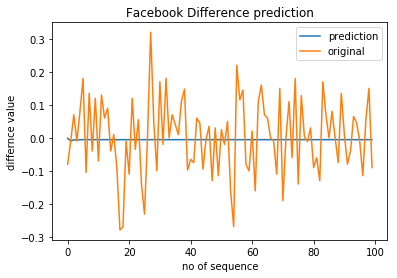

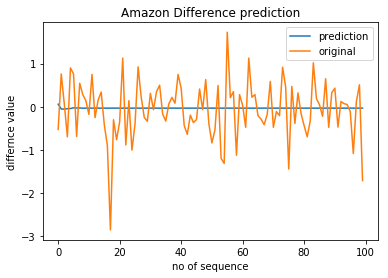

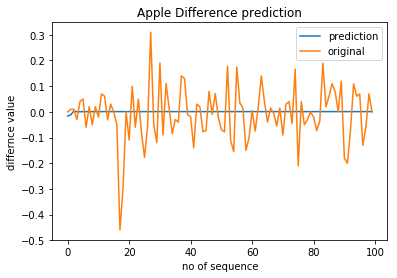

In [53]:
for i in range(len(dfs)):
    plt.plot(prediction_diff[i,:],label="prediction")
    # comment this line in final prediction
    plt.plot(merge_test_output[:,i],label="original")
    plt.title(arr[i][:-4]+' Difference prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('differnce value')
    plt.legend()
    plt.show()

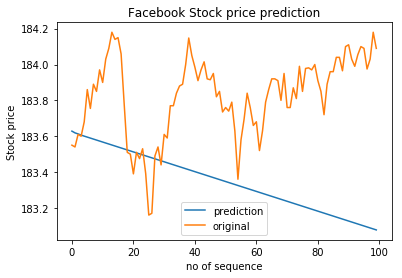

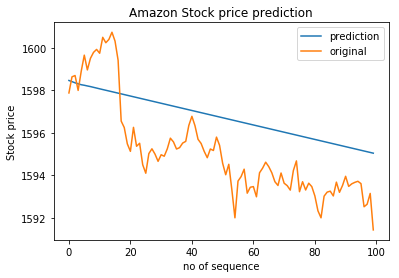

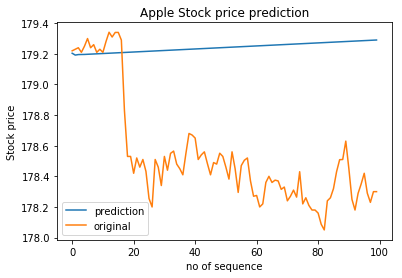

In [54]:
for i in range(len(dfs)):
    plt.plot(prediction_stock[i,:],label="prediction")
    # comment this line in final prediction
    plt.plot(result.iloc[-100:,i].values,label="original")
    plt.title(arr[i][:-4]+' Stock price prediction')
    plt.xlabel('no of sequence')
    plt.ylabel('Stock price')
    plt.legend()
    plt.show()